In [8]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144
import pandas as pd

# ML: Predicting Star Ratings

Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a dataset of venue popularities provided by Yelp.  The dataset contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants. 


## Download and parse the incoming data

We start by downloading the dataset from Amazon S3:

In [9]:
!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'yelp_train_academic_dataset_business.json.gz'

The training data are a series of JSON objects, in a gzipped file. Python supports gzipped files natively: [gzip.open](https://docs.python.org/2/library/gzip.html) has the same interface as `open`, but handles `.gz` files automatically.

In [10]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [11]:
df = pd.DataFrame(data)  
df.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type
0,{u'By Appointment Only': True},vcNAWiLM4dR7D2nwwJ7nCA,"[Doctors, Health & Medical]",Phoenix,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{u'Thursday': {u'close': u'17:00', u'open': u'...",33.499313,-111.983758,"Eric Goldberg, MD",[],True,7,3.5,AZ,business
1,"{u'Take-out': True, u'Price Range': 1, u'Outdo...",JwUE5GmEO-sH1FuwJgKBlQ,[Restaurants],De Forest,"6162 US Highway 51\nDe Forest, WI 53532",{},43.238893,-89.335844,Pine Cone Restaurant,[],True,26,4.0,WI,business
2,"{u'Take-out': True, u'Outdoor Seating': False,...",uGykseHzyS5xAMWoN6YUqA,"[American (Traditional), Restaurants]",De Forest,"505 W North St\nDe Forest, WI 53532","{u'Monday': {u'close': u'22:00', u'open': u'06...",43.252267,-89.353437,Deforest Family Restaurant,[],True,16,4.0,WI,business
3,"{u'Take-out': True, u'Accepts Credit Cards': T...",LRKJF43s9-3jG9Lgx4zODg,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,"4910 County Rd V\nDe Forest, WI 53532","{u'Monday': {u'close': u'22:00', u'open': u'10...",43.251045,-89.374983,Culver's,[],True,7,4.5,WI,business
4,"{u'Take-out': True, u'Has TV': False, u'Outdoo...",RgDg-k9S5YD_BaxMckifkg,"[Chinese, Restaurants]",De Forest,"631 S Main St\nDe Forest, WI 53532","{u'Monday': {u'close': u'22:00', u'open': u'11...",43.240875,-89.343722,Chang Jiang Chinese Kitchen,[],True,3,4.0,WI,business


In [12]:
star_ratings = [row['stars'] for row in data]

## Building models

## city_avg_model
The venues belong to different cities. Ratings in some cities are probably higher than others. We wish to build an estimator to make a prediction based on this, but first we need to work out the average rating for each city.


In [5]:
from collections import defaultdict
star_sum = defaultdict(int)
count = defaultdict(int)

In [13]:
for row, stars in zip(data, star_ratings):
    star_sum[row['city']] = star_sum[row['city']] + stars
    count[row['city']] = count[row['city']] + 1
    # increment the running sum in star_sum
    # increment the running count in count

In [14]:
# calculate average star rating and store in avg_stars
avg_stars = dict()
for city in star_sum:
    avg_stars[city] = float(star_sum[city])/float(count[city])

There should be 167 different cities:

In [16]:
assert len(avg_stars) == 167

In [17]:
print avg_stars

{u'Victoria Park': 4.5, u'Anthem': 3.7818181818181817, u'Apache Junction': 3.6375, u'Morristown': 3.5, u'North Queensferry': 3.5, u'Paradise': 3.46875, u'Surprise': 3.5758426966292136, u'Henderson': 3.6879310344827587, u'Higley': 3.5, u'Rio Verde': 4.0, u'N. Las Vegas': 3.25, u'Verona': 3.8548387096774195, u'Musselburgh': 3.55, u'Central Henderson': 3.5, u'Fort Mcdowell': 4.0, u'Scottsdale': 3.8206757594544327, u'Sun Lakes': 3.2222222222222223, u'Whitney': 4.5, u'Dane': 4.25, u'Atlanta': 3.5, u'Fort Kinnaird': 4.5, u'NELLIS AFB': 4.5, u'Waterloo': 3.6054421768707483, u'South Gyle': 2.5, u'South Las Vegas': 4.5, u'Summerlin South': 3.25, u'DeForest': 4.1, u'Clark County': 3.0, u'Gold Canyon': 3.5, u'Newberry Springs': 3.5, u'Kitchener': 3.6982758620689653, u'Nellis AFB': 4.222222222222222, u'Litchfield Park': 3.7, u'Tolleson': 3.2291666666666665, u'Woolwich': 4.25, u'St Jacobs': 3.5, u'London': 3.0, u'Queensferry': 3.8333333333333335, u'Inverkeithing': 3.0, u'St Clements': 4.5, u'Sunris

We can get that list of tuples from the `.items()` method.

## city_model
Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  We create a custom class CityEstimator for this purpose.

In [18]:
from sklearn import base
from collections import defaultdict
class CityEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self):

        self.avg_stars = dict()
        self.star_sum = defaultdict(int)
        self.count = defaultdict(int)
        
    def fit(self, X, y):
        # Store the average rating per city in self.avg_stars
        self.data = X
        self.star_ratings = y
        for row, stars in zip(self.data, self.star_ratings):
            self.star_sum[row['city']] = self.star_sum[row['city']]+ stars
            self.count[row['city']] = self.count[row['city']] + 1  
        for city in self.star_sum:
            self.avg_stars[city] = float(self.star_sum[city])/float(self.count[city])
        return self
    def predict(self, X):
        y = []
        for row in X:
            temp = self.avg_stars.get(row['city'])
            if temp is not None:
                y.append(temp)
            else:
                #when city does not exist  in the avg_stars dict I am appending with 2.5
                y.append(2.5) 
        return y
 

In [19]:
city_est = CityEstimator()
city_est.fit(data, star_ratings)

CityEstimator()

And let's see if it works.

In [20]:
city_est.predict(data[:5])

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75]

In [21]:
city_est.predict([{'city': 'Timbuktu'}])

[2.5]

## lat_long_model
A city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  We can use the latitude and longitude of a venue as features that help us understand neighborhood dynamics. We make a custom class ColumnSelectTransformer for this purpose.

In [22]:
print df['latitude'].head(n=5)
print df.columns

0    33.499313
1    43.238893
2    43.252267
3    43.251045
4    43.240875
Name: latitude, dtype: float64
Index([u'attributes', u'business_id', u'categories', u'city', u'full_address',
       u'hours', u'latitude', u'longitude', u'name', u'neighborhoods', u'open',
       u'review_count', u'stars', u'state', u'type'],
      dtype='object')


In [23]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and onzjhjjjjhjnhe
        # column for each in self.col_names
        self.df = pd.DataFrame(X)  
        #return self.df
        selected_data = []
        for row in X:
            selected_data.append([row[col] for col in self.col_names])
        return selected_data


Let's test it on a single row, just as a sanity check:

In [24]:
cst = ColumnSelectTransformer(['latitude', 'longitude'])
assert (cst.fit_transform(data[:1])
        == [[data[0]['latitude'], data[0]['longitude']]])

Now, let's feed the output of the transformer in to a `sklearn.neighbors.KNeighborsRegressor`.  As a sanity check, we'll test it with the first 5 rows.  To truly judge the performance, we'd need to make a test/train split.

In [25]:
from sklearn.neighbors import KNeighborsRegressor

data_transform = cst.fit_transform(data)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)
test_data = data[:5]
test_data_transform = cst.transform(test_data)
knn.predict(test_data_transform)

array([ 4. ,  4.2,  4. ,  3.8,  4.2])

In [26]:
from sklearn.pipeline import Pipeline
latlongTrans = ColumnSelectTransformer(['latitude','longitude'])
geoEst = KNeighborsRegressor(n_neighbors=5)
pipe = Pipeline([('geotran', latlongTrans),('est', geoEst)])

This should work the same way.

In [27]:
pipe.fit(data, star_ratings)
pipe.predict(test_data)

array([ 4. ,  4.2,  4. ,  3.8,  4.2])

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1000,center=False).mean()
  after removing the cwd from sys.path.


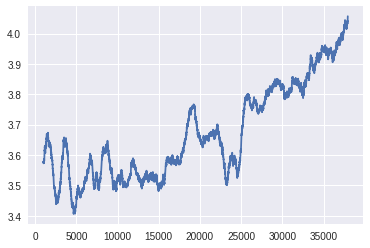

In [28]:
from pandas import rolling_mean, Series
import matplotlib.pyplot as plt

plt.plot(rolling_mean(Series(star_ratings), 1000))

In [29]:
from sklearn.cross_validation import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(data, star_ratings)

/opt/conda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
from sklearn.ensemble import RandomForestRegressor
latlongTrans = ColumnSelectTransformer(['latitude','longitude'])
geoEst = RandomForestRegressor( max_depth=11, min_samples_leaf=64)
geoModel = Pipeline([('geotran', latlongTrans),
                        ('est', geoEst)
                        ])

In [31]:
geoModel.fit(xTrain, yTrain)
geoModel.predict(xTest)

array([ 3.53566082,  3.86510118,  3.4241163 , ...,  3.61480435,
        3.59210095,  3.78494352])

In [ ]:
#now lets look at the categories column for example
cst1 = ColumnSelectTransformer(['categories'])
print cst1.fit_transform(data[:20])

## category_model
While location is important, we could also try seeing how predictive the
venue's category is.  Build an estimator that considers only the categories.

The categories come as a list of strings, but the built-in estimators all need numeric input.  The standard way to deal with categorical features is **one-hot encoding**, also known as dummy variables.  In this approach, each category gets its own column in the feature matrix.  If the row has a given category, that column gets filled with a 1.  Otherwise, it is 0.

The `ColumnSelectTransformer` from the previous model can be used to extract the categories column as a list of strings.  

In [32]:
class DictEncoder(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will come in as a list of lists of lists.  Return a list of
        # dictionaries corresponding to those inner lists.
        list_of_dicts = []
        for sub in X:
            for sub_sub in sub: 
                d = {}
                for el in sub_sub:
                    d[el] = 1
                list_of_dicts.append(d)
        return list_of_dicts
        

In [33]:
#sanity check
assert (DictEncoder().fit_transform([[['a']], [['b', 'c']]])
        == [{'a': 1}, {'b': 1, 'c': 1}])

In [34]:
#Just to check the sequence of ColumnSelectTransformer and Dict Enooder on the data
cst = ColumnSelectTransformer(['categories'])
categ = cst.fit_transform(data)
categ_dict = DictEncoder().fit_transform(categ)
#categ_dict

In [35]:
## import transformers, make instances of each class
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
catcolTrans = ColumnSelectTransformer(['categories'])
catTrans = DictEncoder()   # list of dicts, each element is dict of categories (features)
vecTrans = DictVectorizer()   # nRows x nFeature sparse array, indicates 1 if feature present for this business




In [36]:
categoryModel = Pipeline([(('colselect'), catcolTrans),
                            ('cattran', catTrans),
                            ('vectran', vecTrans),
                            ('est', linear_model.Ridge( alpha = 3 )),
                            ])

In [37]:
categoryModel.fit( xTrain, yTrain)
print "catModel=", categoryModel.score( xTest, yTest ) 

catModel= 0.191185633524


## attribute_model
There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them with one-hot encoding.  The `DictVectorizer` can do this, but only once we've flattened the dictionary to a single level, like so:
```
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```

We can build a custom transformer that flattens the attributes dictionary and then place this in a pipeline with a `DictVectorizer` and a regressor.

We also use a linear model to fit the linear part of some data, and a non-linear model to fit the residual that the linear model can't fit. 

In [38]:
class attrs_class3(base.BaseEstimator, base.TransformerMixin):
#     def __init__(self, debug=False):
#         self.debug = debug
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, M):
        list_of_dicts = []
        for sub in M:
            for sub_sub in sub: 
                list_of_dicts.append(sub_sub)
        result_list = []
        for d in list_of_dicts:
            result_list.append(self.flattenDict(d,{},''))
        return result_list

    def flattenDict(self, inDict, flatDict={}, preKey=''): 
#         if self.debug:
#             print '*called flattenDict on ', inDict
        if type(inDict) == type({}): 
            keys = inDict.keys() 
            for key in keys: 
                keyOut = preKey + ' '.join( key.strip().split() ) 
                tmp = inDict[key]
#                 if self.debug:
#                     print '*processing2 tmp=', tmp, 'with type=', type(tmp)
                if type(tmp) == type({}):
                    flatDict = self.flattenDict(tmp,flatDict,keyOut+'_')

                # boolean values
                elif isinstance(tmp, (bool)):
                    if tmp:
                        flatDict[keyOut] = 1
                    else:
                        flatDict[keyOut] = 0

                # string values
                elif isinstance(tmp, (str,unicode)):
                    flatDict[keyOut + '_' + str(tmp) ] = 1

                # numeric values
                elif isinstance(tmp, (int, float)) :
                    flatDict[keyOut + '_' + str(tmp) ] = 1


                #warn on other values
                else:
                    print "OTHER! tmp=", tmp, 'type=', type(tmp)
                    

        elif type(inDict) == type('a'):
            flatDict[ inDict ] = 1
        else:
            print "WARNING2"
        return flatDict
    

#flattenDict(inDict)

cst = ColumnSelectTransformer(['attributes'])
attrs = cst.fit_transform(data)
attr_flattened_obj = attrs_class3() 
attrs_flat = attr_flattened_obj.transform(attrs)
#attrs_flat
#attrs_flat = attr_flattened_obj.fit_transform(attrs)
#print attrs_flat)
#V = DictVectorizer().fit_transform(attrs_flat)

In [39]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV


xTrain, xTest, yTrain, yTest = train_test_split(data, star_ratings)

attrcolTrans = ColumnSelectTransformer(['attributes'])
attrTrans = attrs_class3() # list of dicts, each element is dict of categories (features)
vecTrans = DictVectorizer(sparse = True)# nRows x nFeature sparse array, indicates 1 if feature present for this business


/opt/conda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [40]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn import neighbors
from sklearn import ensemble
from sklearn.pipeline import Pipeline, FeatureUnion

class EnsembleTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_estimator, residual_estimators):
        self.base_estimator = base_estimator
        self.residual_estimators = residual_estimators
    
    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        y_err = y - self.base_estimator.predict(X)
        for est in self.residual_estimators:
            est.fit(X, y_err)
        return self
    
    def transform(self, X):
        all_ests = [self.base_estimator] + list(self.residual_estimators)
        return np.array([est.predict(X) for est in all_ests]).T

attrcolTrans = ColumnSelectTransformer(['attributes'])
attrTrans = attrs_class3() # list of dicts, each element is dict of categories (features)
vecTrans = DictVectorizer(sparse = True)# nRows x nFeature sparse array, indicates 1 if feature present for this business


ensemble_pipe = Pipeline([
        ('attrselect', attrcolTrans),
        ('attrtran', attrTrans),
        ('vectran', vecTrans),
        ('ensemble', EnsembleTransformer(
                linear_model.LinearRegression(),
                (neighbors.KNeighborsRegressor(n_neighbors=10),
                 ensemble.RandomForestRegressor(min_samples_leaf=20)))),
        ('blend', linear_model.LinearRegression())
])

ensemble_pipe.fit(xTrain, yTrain)
ensemble_pipe.score( xTest, yTest ) 


0.081359041920282107

In [41]:
ensemble_pipe.predict(xTest)-yTest

array([ 1.30588185, -0.07202187,  0.63496556, ...,  1.33560891,
       -0.43943566, -1.21950895])

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ensemble_pipe.predict(xTest), yTest)

0.72292276798122135

## full_model
So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In [43]:
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
    
    def fit(self, X, y):
        # Fit the stored estimator.
        # Question: what should be returned?
        self.estimator.fit(X,y)
        return self
    
    def transform(self, X):
        # Use predict on the stored estimator as a "transformation".
        # Be sure to return a 2-D array.
        pre = self.estimator.predict(X)
        return [[a] for a in pre]

In [44]:
city_trans = EstimatorTransformer(city_est)
city_trans.fit(data, star_ratings)
assert ([r[0] for r in city_trans.transform(data[:5])]
        == city_est.predict(data[:5]))

In [45]:
city_trans = EstimatorTransformer(city_est)
latlong_trans = EstimatorTransformer(geoModel)
categ_trans = EstimatorTransformer(categoryModel)
attr_trans = EstimatorTransformer(ensemble_pipe)

In [46]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
            ('city', city_trans),
            ('latlong', latlong_trans ),
            ('category', categ_trans ),
            ('attribute', attr_trans ),
    ])

#EstimatorTransformer(CityEstimator()

In [49]:
union.fit(data, star_ratings)
trans_data = union.transform(data[:10])
assert trans_data.shape == (10, 4)

In [ ]:
full_est = Pipeline(
    [('union', union ),
     ('blend', linear_model.LinearRegression())
    ]
)

In [ ]:
full_est.fit(data, star_ratings)
full_est.predict(xTest)

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*